In [21]:
import numpy as np
np.set_printoptions(threshold=np.inf, suppress=True)
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

In [46]:
data = np.load("episode_0.pkl", "rb", allow_pickle=True)
print(np.shape(data))
q = data[:, 11:15]
rot = R.from_quat(q).as_euler('xyz', degrees=True)
print(rot)

(3340, 17)
[[179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.02004433   0.85334265]
 [179.8103853   -0.0200

In [3]:
data = np.load("rollouts/mode1_closetoxarm/episode_0.pkl", "rb", allow_pickle=True)

In [4]:
np.shape(data)

(4223, 17)

In [5]:
q = data[:, 11:15]
rot = R.from_quat(q).as_rotvec()
print(rot)

[[-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709   3.13819367]
 [-0.00051026 -0.0233709 

In [6]:
sparse_data = data[::10, :]
print(np.shape(sparse_data))

(423, 17)


In [22]:
from scipy.spatial.transform import Rotation as R

def quaternions_to_rotvecs(data: np.ndarray) -> np.ndarray:
    if data.ndim != 2 or data.shape[1] != 17:
        raise ValueError(f"Expected input shape (N,17), got {data.shape}")

    # Extract the two quaternion blocks: each is shape (N, 4) in (w, x, y, z) order.
    q1 = data[:, 3:7]    # columns 3–6
    q2 = data[:, 11:15]  # columns 12–15
    # rpy = R.from_quat(q2).as_rotvec()

    # Build Rotation objects and convert to rotation vectors
    rot1 = R.from_quat(q1).as_rotvec()  # shape (N, 3)
    rot2 = R.from_quat(q2).as_rotvec()  # shape (N, 3)
    # rot2 = R.from_euler('xyz', rpy).as_rotvec()  # shape (N, 3)

    out = np.concatenate([
        data[:, 0:3],     # kinova position
        rot1,             # kinova rotation vector
        data[:, 7:8],     # kinova gripper
        data[:, 8:11],    # xarm position
        rot2,             # xarm rotation vector
        data[:, 15:16],   # xarm gripper
    ], axis=1)

    # Verify result has shape (N, 15)
    assert out.shape[1] == 14, f"Output has wrong shape {out.shape}"
    return out


In [3]:
mode1_list = []
mode1_lens = []
for i in range(14):
    try:
        data = np.load("rollouts/mode1_closetoxarm/episode_{}.pkl".format(i), "rb", allow_pickle=True)
        data = quaternions_to_rotvecs(data)
        pad_num = 5000 - len(data)
        print(pad_num)
        for _ in range(pad_num):
            data = np.vstack([data, data[-1]])
        mode1_list.append(data)
        mode1_lens.append(len(data))
    except FileNotFoundError:
        pass

777
775
489
754
428
732
646
473
383
691


In [23]:
mode1_sparse_list = []
mode1_sparse_lens = []
for i in range(14):
    try:
        data = np.load("rollouts/mode1_closetoxarm/episode_{}.pkl".format(i), "rb", allow_pickle=True)
        data = data[::5, :]
        data = quaternions_to_rotvecs(data)
        pad_num = 1000 - len(data)
        print(pad_num)
        for _ in range(pad_num):
            data = np.vstack([data, data[-1]])
        mode1_sparse_list.append(data)
        mode1_sparse_lens.append(len(data))
    except FileNotFoundError:
        pass

155
155
97
150
85
146
129
94
76
138


In [4]:
print("Number of mode 1 episodes:", len(mode1_list))
print("Mode 1 lengths:", mode1_lens)
print("Mode 1 longest episode length:", max(mode1_lens))

Number of mode 1 episodes: 10
Mode 1 lengths: [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
Mode 1 longest episode length: 5000


In [24]:
print("Number of mode 1 episodes:", len(mode1_sparse_list))
print("Mode 1 lengths:", mode1_sparse_lens)
print("Mode 1 longest episode length:", max(mode1_sparse_lens))

Number of mode 1 episodes: 10
Mode 1 lengths: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
Mode 1 longest episode length: 1000


In [5]:
mode2_list = []
mode2_lens = []
for i in range(11):
    try:
        data = np.load("rollouts/mode2_closetokinova/episode_{}.pkl".format(i), "rb", allow_pickle=True)
        data = quaternions_to_rotvecs(data)
        pad_num = 5000 - len(data)
        print(pad_num)
        for _ in range(pad_num):
            data = np.vstack([data, data[-1]])
        mode2_list.append(data)
        mode2_lens.append(len(data))
    except FileNotFoundError:
        pass

347
396
675
318
505
100
820
804
555
521


In [25]:
mode2_sparse_list = []
mode2_sparse_lens = []
for i in range(11):
    try:
        data = np.load("rollouts/mode2_closetokinova/episode_{}.pkl".format(i), "rb", allow_pickle=True)
        data = data[::5, :]
        data = quaternions_to_rotvecs(data)
        pad_num = 1000 - len(data)
        print(pad_num)
        for _ in range(pad_num):
            data = np.vstack([data, data[-1]])
        mode2_sparse_list.append(data)
        mode2_sparse_lens.append(len(data))
    except FileNotFoundError:
        pass

69
79
135
63
101
20
164
160
111
104


In [6]:
print("Number of mode 2 episodes:", len(mode2_list))
print("Mode 2 lengths:", mode2_lens)
print("Mode 2 longest episode length:", max(mode2_lens))

Number of mode 2 episodes: 10
Mode 2 lengths: [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
Mode 2 longest episode length: 5000


In [26]:
print("Number of mode 2 episodes:", len(mode2_sparse_list))
print("Mode 2 lengths:", mode2_sparse_lens)
print("Mode 2 longest episode length:", max(mode2_sparse_lens))

Number of mode 2 episodes: 10
Mode 2 lengths: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
Mode 2 longest episode length: 1000


In [12]:
mode3_list = []
mode3_lens = []
for i in range(11):
    try:
        data = np.load("rollouts/mode3_over/episode_{}.pkl".format(i), "rb", allow_pickle=True)
        data = quaternions_to_rotvecs(data)
        pad_num = 5000 - len(data)
        print(pad_num)
        for _ in range(pad_num):
            data = np.vstack([data, data[-1]])
        mode3_list.append(data)
        mode3_lens.append(len(data))
    except FileNotFoundError:
        pass

315
288
729
606
708
394
178
671
318
636


In [14]:
mode3_sparse_list = []
mode3_sparse_lens = []
for i in range(11):
    try:
        data = np.load("rollouts/mode3_over/episode_{}.pkl".format(i), "rb", allow_pickle=True)
        data = quaternions_to_rotvecs(data)
        data = data[::10, :]
        pad_num = 500 - len(data)
        print(pad_num)
        for _ in range(pad_num):
            data = np.vstack([data, data[-1]])
        mode3_sparse_list.append(data)
        mode3_sparse_lens.append(len(data))
    except FileNotFoundError:
        pass

31
28
72
60
70
39
17
67
31
63


In [13]:
print("Number of mode 3 episodes:", len(mode3_list))
print("Mode 3 lengths:", mode3_lens)
print("Mode 3 longest episode length:", max(mode3_lens))

Number of mode 3 episodes: 10
Mode 3 lengths: [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
Mode 3 longest episode length: 5000


In [15]:
print("Number of mode 3 episodes:", len(mode3_sparse_list))
print("Mode 3 lengths:", mode3_sparse_lens)
print("Mode 3 longest episode length:", max(mode3_sparse_lens))

Number of mode 3 episodes: 10
Mode 3 lengths: [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]
Mode 3 longest episode length: 500


In [14]:
np.shape(mode1_list[0])

(5000, 14)

In [17]:
np.shape(mode1_sparse_list[0])

(500, 14)

In [7]:
mode1 = np.array(mode1_list)
mode2 = np.array(mode2_list)
# mode3 = np.array(mode3_list)

In [27]:
mode1_sparse = np.array(mode1_sparse_list)
mode2_sparse = np.array(mode2_sparse_list)
# mode3_sparse = np.array(mode3_sparse_list)

In [8]:
np.shape(mode1)

(10, 5000, 14)

In [14]:
np.shape(mode1_sparse)

(10, 330, 14)

In [9]:
expert_states = np.concatenate([mode1, mode2], axis=0)
print(np.shape(expert_states))

(20, 5000, 14)


In [28]:
expert_states_sparse = np.concatenate([mode1_sparse, mode2_sparse], axis=0)
print(np.shape(expert_states_sparse))

(20, 1000, 14)


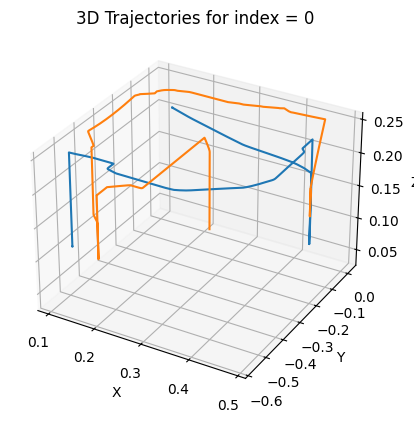

In [30]:
from mpl_toolkits.mplot3d import Axes3D

def plot_trajectories(arr: np.ndarray, i: int):
    """
    Plots arr[i, :, :3] and arr[i, :, 7:10] in 3D.

    Parameters
    ----------
    arr : ndarray
        Array of shape (20, 5000, 14).
    i : int
        Which of the 20 trajectories to plot.
    """
    # Extract the two 3D trajectories
    x1, y1, z1 = arr[i, :, 0], arr[i, :, 1], arr[i, :, 2]
    x2, y2, z2 = arr[i, :, 7], arr[i, :, 8], arr[i, :, 9]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x1, y1, z1)
    ax.plot(x2, y2, z2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'3D Trajectories for index = {i}')
    plt.show()

# Example: change `i` below to plot a different sample
plot_trajectories(expert_states_sparse, i=0)

In [12]:
np.save("data/expert_actions_rotvec_5000.npy", expert_states)

In [31]:
np.save("data/expert_actions_rotvec_sparse_1000.npy", expert_states_sparse)

In [32]:
pot_states1 = []
pot_states2 = []

for traj in mode1_sparse:
    diff_mask = np.abs(traj[:, 6] - traj[0, 6]) > 0.001
    changed_indices = np.nonzero(diff_mask)[0]
    desired_idx = None
    for idx in changed_indices:
        if idx > 0:
            desired_idx = idx
            break
    pot_states1.append(traj[desired_idx, :3])

    diff_mask = np.abs(traj[:, 13] - traj[0, 13]) > 0.001
    changed_indices = np.nonzero(diff_mask)[0]
    desired_idx = None
    for idx in changed_indices:
        if idx > 0:
            desired_idx = idx
            break
    pot_states2.append(traj[desired_idx, 7:10])

for traj in mode2_sparse:
    diff_mask = np.abs(traj[:, 6] - traj[0, 6]) > 0.001
    changed_indices = np.nonzero(diff_mask)[0]
    desired_idx = None
    for idx in changed_indices:
        if idx > 0:
            desired_idx = idx
            break
    pot_states1.append(traj[desired_idx, :3])

    diff_mask = np.abs(traj[:, 13] - traj[0, 13]) > 0.001
    changed_indices = np.nonzero(diff_mask)[0]
    desired_idx = None
    for idx in changed_indices:
        if idx > 0:
            desired_idx = idx
            break
    pot_states2.append(traj[desired_idx, 7:10])


In [33]:
np.shape(pot_states2)

(20, 3)

In [34]:
pot_states1 = np.array(pot_states1)
pot_states2 = np.array(pot_states2)

In [16]:
np.shape(pot_states1)

(20, 3)

In [35]:
pot_states = np.hstack([pot_states1, pot_states2])
print(np.shape(pot_states))

(20, 6)


In [36]:
print(pot_states[0])
print(pot_states1[0])
print(pot_states2[0])

[ 0.47816622 -0.14264476  0.09862956  0.20981865  0.0048536   0.02984436]
[ 0.47816622 -0.14264476  0.09862956]
[0.20981865 0.0048536  0.02984436]


In [37]:
np.save("data/pot_states1_1000.npy", pot_states1)
np.save("data/pot_states2_1000.npy", pot_states2)
np.save("data/pot_states_1000.npy", pot_states)